In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

C:\Users\hugma\AppData\Local\Temp\ipykernel_30728\166682349.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
filelocation_TET = 'NDT_all_12thDec_uncleaned.csv'
feelings = ['MetaAwareness','Presence','PhysicalEffort','MentalEffort','Boredom', 'Receptivity', 'EmotionalIntensity', 'Clarity', 'Release', 'Bliss', 'Embodiment', 'Insightfulness', 'Anxiety', 'SpiritualExperience']
header = "Subject"
no_dimensions = 2
colours = {0:'red',1:'green',2:'blue',3:'orange',4:'pink',5:'yellow'}
n_clust = 3
headers = {'Subject':0, 'Week':1, 'Session':2}
lcm = 332640
n_rep = 1

In [3]:
class traj_kmeans_clustering_trunc:

    def __init__(self,data, feelings, heading, principal_components, n_clust):
        data[["principal componant 1", "principal componant 2"]] = data[feelings].dot(principal_components)
        split_dict = {}
        for (subject, week, session), group in data.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group.copy()
        stacked_array = np.stack([df.iloc[0:43,40:42].values for df in split_dict.values()], axis=2)
        self.data = np.transpose(stacked_array,(1,0,2))
        self.data_all = np.stack([df.iloc[0:43,0:42].values for df in split_dict.values()], axis=2)
        self.heading = heading
        self.n_clust = n_clust
    def data_make(self):
        return self.data
    def traj_kmeans_mean(self, nrep, avg):
        min_dist = np.inf
        seed_method = '++'
        sum_dist = np.zeros(nrep)
        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=self.data.shape[2])
            clust = np.full((self.data.shape[0], self.data.shape[1], self.n_clust), np.nan)
            dist = np.full((self.data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((self.data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(self.data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(self.data.shape[2])
                    clust[:, :, clust_index] = self.data[:, :, index]

                for _ in range(10000):
                    for i in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, i], axis=2))
                        print(mat)
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(self.data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = self.data[:, :, index]

            aux = np.zeros(self.data.shape[2])
            new_column = np.ones((self.data.shape[1],1, self.data.shape[2]),dtype=int)
            for i in range(0,self.data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  
            sum_dist[n] = np.sum(dist[np.arange(self.data.shape[2]),id_n])
        return id_n, clust, dist, aux, data_all_clust, sum_dist
    def traj_kmeans_mean_diffs(self, nrep, avg):
        data = np.zeros_like(self.data)

        for i in range(self.data.shape[2]):
            for j in range(self.data.shape[0]):
                for k in range(self.data.shape[1] - 1):
                    data[j, k, i] = self.data[j, k + 1, i] - self.data[j, k, i]
        min_dist = np.inf
        seed_method = '++'
        
        sum_dist = np.zeros(nrep)
        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=data.shape[2])
            clust = np.full((data.shape[0], data.shape[1], self.n_clust), np.nan)
            dist = np.full((data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(data.shape[2])
                    clust[:, :, clust_index] = data[:, :, index]

                for _ in range(10000):
                    for i in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = data[:, :, index]

            aux = np.zeros(data.shape[2])
            new_column = np.ones((data.shape[1],1, data.shape[2]),dtype=int)
            for i in range(0,data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  
            sum_dist[n] = np.sum(dist[np.arange(self.data.shape[2]),id_n])
        return id_n, clust, dist, aux, data_all_clust, data, sum_dist
    def traj_plots(self, colours, id_n):
        ax = plt.subplot()


        for i in range(0, self.data.shape[2]):
    
            x_values = []
            y_values = []

    
            for j in range(0, self.data.shape[1]):
                x_values.append(self.data[0][j][i])
                y_values.append(self.data[1][j][i])
            ax.plot(x_values,y_values,label=f"line {i}", color=colours[id_n[i]])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
            ax.plot(self.data[0][0][i],color='black')
            ax.plot(self.data[1][0][i],color='black')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def traj_identifier(self, data_all_clust):
        new_column = np.ones((data_all_clust.shape[0],1, data_all_clust.shape[2]),dtype=int)
        for i in range(0,data_all_clust.shape[2]):
            new_column[:,0,i] = i
        data_all_clust_fin = np.column_stack((data_all_clust, new_column)) 
        return data_all_clust_fin   
    def indiv_plots(self, data_all_clust,headers, colours):
        group_by_header = {}

        for i in range(data_all_clust.shape[2]):  # Iterate over the second dimension
            head = tuple(data_all_clust[0][headers[self.heading]][i])
            if head not in group_by_header:
                group_by_header[head] = []
            group_by_header[head].append(data_all_clust[:,:,i])
        names = group_by_header.keys()
        for name in names:
             name_tot = ''.join(name)
             plt.figure()
             plt.title(name_tot)
             for i in range(0,len(group_by_header[name])):
                 x_values = []
                 y_values = []
                 for j in range(0,len(group_by_header[name][i])):
                     x_values.append(group_by_header[name][i][j][-4])
                     y_values.append(group_by_header[name][i][j][-3])
                 
                 plt.plot(x_values,y_values,label=f"line {i}", color=colours[group_by_header[name][i][0][-2]])
                 plt.xlabel('principal componant 1 (bored/effort)')
                 plt.ylabel('principal componant 2 (calm)')
                 plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
                 plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
                 plt.plot(self.data[0][0][i],color='black')
                 plt.plot(self.data[1][0][i],color='black')
                 plt.xlim(-6,6)
                 plt.ylim(-1,2)
        
    def centroid_plotter(self,clust,colours):
        for i in range(0,clust.shape[2]):
            plt.figure()
            plt.title(f'cluster_centroid_{i}')
            x_values = []
            y_values = []
            
            for k in range(0,clust.shape[1]):
                x_values.append(clust[0,k,i])
                y_values.append(clust[1,k,i])
            plt.plot(x_values,y_values,label=f"line {i}", color=colours[i])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")     
            plt.xlim(-6,6)
            plt.ylim(-1,2)
            
    def centroid_plotter_diff(self,clust,colours):
        for i in range(0,clust.shape[2]):
            plt.figure()
            plt.title(f'cluster_centroid_{i}')
            x_values = []
            y_values = []

            for k in range(0,clust.shape[1]):
                x_values.append(sum(clust[0,0:k,i]))
                y_values.append(sum(clust[1,0:k,i]))
        
            plt.plot(x_values,y_values,label=f"line {i}", color=colours[i])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")     
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def silhouette_et(self, data, id_out, n_clust):
        dist_pairwise = cdist(np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), 
                          np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), metric='euclidean')

        a = np.zeros(data.shape[2])
        b = np.zeros(data.shape[2])
        s = np.zeros(data.shape[2])

        for i in range(data.shape[2]):
            # Calculate the number of points in the same cluster as the current point
            cluster_size = np.sum(id_out == id_out[i])
            
            # If the cluster has only one point, assign a silhouette score of 0
            if cluster_size <= 1:
                s[i] = 0
                continue

            # within-cluster distance
            a[i] = np.nansum(dist_pairwise[i, id_out == id_out[i]]) / (cluster_size - 1)

            # between-cluster distance
            not_clust = np.setdiff1d(np.arange(1, n_clust + 1), id_out[i])

            bmin = np.inf
            for j in not_clust:
                # Calculate the number of points in the current cluster
                cluster_size_j = np.sum(id_out == j)
                
                # If the cluster has no points assigned, skip the calculation
                if cluster_size_j == 0:
                    continue
                    
                b_aux = np.nansum(dist_pairwise[i, id_out == j]) / cluster_size_j
                bmin = min(b_aux, bmin)

            b[i] = bmin

            s[i] = (b[i] - a[i]) / max(a[i], b[i])
        return s

In [4]:
class traj_kmeans_clustering_interpolate:

    def __init__(self,data, feelings, heading, principal_components, n_clust):
        data[["principal componant 1", "principal componant 2"]] = data[feelings].dot(principal_components)
        split_dict_all = {}
        for (subject, week, session), group in data.groupby(['Subject', 'Week', 'Session']):
            split_dict_all[(subject, week, session)] = group.copy()
        prin = ['principal componant 1', 'principal componant 2']
        split_dict = {}
        interpolated_values_dict = {}

        for (subject, week, session), group in data.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group[prin].copy()

        for key, value in split_dict.items():
            
            no_steps = lcm // (value.shape[0]-1)
            step_length = 1 / no_steps
            
            interpolated_values_list = []
            
            for j in range(value.shape[1]):  # Iterate over columns of the principal component values
                new_values = []  # List to store interpolated values for each column
                
                for i in range(value.shape[0]-1):  # Iterate over rows of the principal component values
                    # Generate new times at equal steps
                    new_times = np.arange(i, i + 1, step_length)
                    
                    # Perform linear interpolation for the current principal component+
                    new_value = np.interp(new_times, np.arange(value.shape[0]), value.iloc[:, j])
                    
                    # Append the interpolated value to the list
                    new_values.extend(new_value)
                
                # Append the list of interpolated values for the current column to the main list
                interpolated_values_list.append(new_values)
            
            # Convert the list of interpolated values to a numpy array
            interpolated_values_array = np.array(interpolated_values_list)
            
            # Store the interpolated values in the dictionary using the key
            interpolated_values_dict[key] = interpolated_values_array
        stacked_array = np.stack([df for df in interpolated_values_dict.values()],axis=2)
        self.data = stacked_array
        self.data_all = np.stack([df.iloc[0:43,0:42].values for df in split_dict_all.values()], axis=2)
        self.heading = heading
        self.n_clust = n_clust
    def data_maker(self):
        return self.data
    def traj_kmeans_mean(self, nrep, avg):
        min_dist = np.inf
        seed_method = '++'

        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=self.data.shape[2])
            clust = np.full((self.data.shape[0], self.data.shape[1], self.n_clust), np.nan)
            dist = np.full((self.data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((self.data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(self.data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(self.data.shape[2])
                    clust[:, :, clust_index] = self.data[:, :, index]

                for _ in range(1000):
                    for i in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(self.data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(self.data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = self.data[:, :, index]

            aux = np.zeros(self.data.shape[2])
            new_column = np.ones((self.data.shape[1],1, self.data.shape[2]),dtype=int)
            for i in range(0,self.data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  

        return id_n, clust, dist, aux, data_all_clust
    def traj_kmeans_mean_diffs(self, nrep, avg):
        data = np.zeros_like(self.data)

        for i in range(self.data.shape[2]):
            for j in range(self.data.shape[0]):
                for k in range(self.data.shape[1] - 1):
                    data[j, k, i] = self.data[j, k + 1, i] - self.data[j, k, i]
        min_dist = np.inf
        seed_method = '++'

        for n in range(nrep):
            id_n = np.random.randint(self.n_clust, size=data.shape[2])
            clust = np.full((data.shape[0], data.shape[1], self.n_clust), np.nan)
            dist = np.full((data.shape[2], self.n_clust), np.nan)
            dist_init = np.full((data.shape[2], self.n_clust), np.nan)

            if seed_method == 'rand_mean':
                for i in range(self.n_clust):
                    clust[:, :, i] = np.nanmean(data[:, :, id_n == i], axis=2)

            elif seed_method == '++':
                for clust_index in range(self.n_clust):
                    index = np.random.randint(data.shape[2])
                    clust[:, :, clust_index] = data[:, :, index]

                for _ in range(1000):
                    for i in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, i], axis=2))
                        dist[:, i] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    for i in range(data.shape[2]):
                        id_n[i] = np.argmin(dist[i])

                    for clust_index in range(self.n_clust):
                        mat = np.abs(data - np.expand_dims(clust[:, :, clust_index], axis=2))
                        dist_init[:, clust_index] = np.nanmean(np.sqrt(mat[0, :, :] ** 2 + mat[1, :, :] ** 2), axis=0)

                    proba = np.cumsum((np.min(dist_init, axis=1)) ** 2) / np.sum((np.min(dist_init, axis=1)) ** 2)
                    index = np.argmax(proba > np.random.rand())
                    clust[:, :, clust_index] = data[:, :, index]

            aux = np.zeros(data.shape[2])
            new_column = np.ones((data.shape[1],1, data.shape[2]),dtype=int)
            for i in range(0,data.shape[2]):
                new_column[:,:,i] = id_n[i]
            data_all_clust = np.column_stack((self.data_all, new_column))  

        return id_n, clust, dist, aux, data_all_clust, data
    def traj_plots(self, colours, id_n):
        ax = plt.subplot()


        for i in range(0, self.data.shape[2]):
    
            x_values = []
            y_values = []

    
            for j in range(0, self.data.shape[1]):
                x_values.append(self.data[0][j][i])
                y_values.append(self.data[1][j][i])
            ax.plot(x_values,y_values,label=f"line {i}", color=colours[id_n[i]])
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
            plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
            ax.plot(self.data[0][0][i],color='black')
            ax.plot(self.data[1][0][i],color='black')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
    def traj_identifier(self, data_all_clust):
        new_column = np.ones((data_all_clust.shape[0],1, data_all_clust.shape[2]),dtype=int)
        for i in range(0,data_all_clust.shape[2]):
            new_column[:,0,i] = i
        data_all_clust_fin = np.column_stack((data_all_clust, new_column)) 
        return data_all_clust_fin   
    def indiv_plots(self, data_all_clust,headers, colours):
        group_by_header = {}

        for i in range(data_all_clust.shape[2]):  # Iterate over the second dimension
            head = tuple(data_all_clust[0][headers[self.heading]][i])
            if head not in group_by_header:
                group_by_header[head] = []
            group_by_header[head].append(data_all_clust[:,:,i])
        names = group_by_header.keys()
        for name in names:
             name_tot = ''.join(name)
             plt.figure()
             plt.title(name_tot)
             for i in range(0,len(group_by_header[name])):
                 x_values = []
                 y_values = []
                 for j in range(0,len(group_by_header[name][i])):
                     x_values.append(group_by_header[name][i][j][-4])
                     y_values.append(group_by_header[name][i][j][-3])
                 
                 plt.plot(x_values,y_values,label=f"line {i}", color=colours[group_by_header[name][i][0][-2]])
                 plt.xlabel('principal componant 1 (bored/effort)')
                 plt.ylabel('principal componant 2 (calm)')
                 plt.scatter(x_values[0], y_values[0], color='black', marker='o', label=f"line {i} - start", facecolors = 'None')
                 plt.scatter(x_values[-1], y_values[-1], color='black', marker='o', label=f"line {i} - end")
                 plt.plot(self.data[0][0][i],color='black')
                 plt.plot(self.data[1][0][i],color='black')
                 plt.xlim(-6,6)
                 plt.ylim(-1,2)
        def silhouette_et(self, data, id_out, n_clust):
            dist_pairwise = cdist(np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), 
                            np.transpose(data.reshape((data.shape[0] * data.shape[1], data.shape[2]))), metric='euclidean')

            a = np.zeros(data.shape[2])
            b = np.zeros(data.shape[2])
            s = np.zeros(data.shape[2])

            for i in range(data.shape[2]):
                # Calculate the number of points in the same cluster as the current point
                cluster_size = np.sum(id_out == id_out[i])
                
                # If the cluster has only one point, assign a silhouette score of 0
                if cluster_size <= 1:
                    s[i] = 0
                    continue

                # within-cluster distance
                a[i] = np.nansum(dist_pairwise[i, id_out == id_out[i]]) / (cluster_size - 1)

                # between-cluster distance
                not_clust = np.setdiff1d(np.arange(1, n_clust + 1), id_out[i])

                bmin = np.inf
                for j in not_clust:
                    # Calculate the number of points in the current cluster
                    cluster_size_j = np.sum(id_out == j)
                    
                    # If the cluster has no points assigned, skip the calculation
                    if cluster_size_j == 0:
                        continue
                        
                    b_aux = np.nansum(dist_pairwise[i, id_out == j]) / cluster_size_j
                    bmin = min(b_aux, bmin)

                b[i] = bmin

                s[i] = (b[i] - a[i]) / max(a[i], b[i])
            return s

In [5]:
class csv_splitter:

    def __init__(self,excel_file_name):
        self.excel_file_location = f'c:\\Users\\hugma\\diss\\{excel_file_name}'
        self.dataframes = None
    def read_excel(self):
        try:
            df_excel_file_name = pd.read_csv(self.excel_file_location)
            return df_excel_file_name
        except Exception as e:
            print(f"error reading Excel file: {e}")
    def split_by_header(self,df_excel_file_name, heading):
        if heading not in df_excel_file_name.columns:
            print(f"Error: '{heading}' not found in DataFrame columns.")
            return None
        heading_values = df_excel_file_name[heading].unique()
        split_df = {value: df_excel_file_name[df_excel_file_name[heading] == value] for value in heading_values}
        split_df_array = [[key, value] for key, value in split_df.items()]
        return split_df, split_df_array

In [6]:
class principal_component_finder:

    def __init__(self,csv_file, feelings,no_dimensions):
        self.csv_file_TET = csv_file[feelings]
        corr_matrix = self.csv_file_TET.corr()
        pca = PCA(n_components=no_dimensions)
        self.principal_components=pca.fit_transform(corr_matrix)
        self.explained_variance_ratio = pca.explained_variance_ratio_
    def PCA_TOT(self):
        df_TET_feelings_prin = self.csv_file_TET.dot(self.principal_components)
        for i in range(0,self.principal_components.shape[1]):
            y_values = []
            for j in range(0,len(feelings)):
                y_values.append(self.principal_components[j][i])
            plt.figure()
            plt.bar(feelings,y_values)
            plt.title(f'principal componant {i+1}')
            plt.xticks(rotation=45, ha='right')
        plt.figure()
        plt.scatter(df_TET_feelings_prin[0],df_TET_feelings_prin[1], s=0.5)
        plt.xlabel('principal componant 1 (bored/effort)')
        plt.ylabel('principal componant 2 (calm)')
        plt.xlim(-6,6)
        plt.ylim(-1,2)
        
        return self.principal_components, self.explained_variance_ratio, df_TET_feelings_prin
    def PCA_split(self,split_df_array):
        split_df_array_TET = [[split_df_array[i][0],split_df_array[i][1][feelings]] for i in range(0,len(split_df_array))]
        split_csv_TET = {split_df_array_TET[i][0]: split_df_array_TET[i][1] for i in range(0,len(split_df_array))}
        df_TET_feelings_prin_dict = {name: split_csv_TET[name].dot(self.principal_components) for name in split_csv_TET.keys()}
        for key,value in df_TET_feelings_prin_dict.items():
            plt.figure()
            plt.scatter(value[0],value[1],s=0.5)
            plt.title(key)
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
            plt.show()
        return df_TET_feelings_prin_dict


In [7]:
csv_splitter_instance = csv_splitter(filelocation_TET)
df_csv_file = csv_splitter_instance.read_excel()
split_df, split_csv_array = csv_splitter_instance.split_by_header(df_csv_file,header)

In [8]:
df_csv_file

Subject    Week Session Condition  MetaAwareness  Presence  \
0        s01\  week_1  run_01     Intro       0.079752  0.157927   
1        s01\  week_1  run_01     Intro       0.090521  0.154184   
2        s01\  week_1  run_01    Breath       0.103346  0.170191   
3        s01\  week_1  run_01    Breath       0.113467  0.184691   
4        s01\  week_1  run_01    Breath       0.122709  0.201506   
...       ...     ...     ...       ...            ...       ...   
24115    s21\  week_4  run_06       END       0.273993  0.471893   
24116    s21\  week_4  run_06       END       0.225174  0.412085   
24117    s21\  week_4  run_06       END       0.191975  0.366937   
24118    s21\  week_4  run_06       END       0.179512  0.319874   
24119    s21\  week_4  run_06       END       0.158047  0.288315   

       PhysicalEffort  MentalEffort   Boredom  Receptivity  ...     delta  \
0            0.986157      0.864791  0.358931     0.325571  ...       NaN   
1            0.988758      0.846303  0.335205     0.327787  ...       NaN   
2            0.996748      0.830982  0.351663     0.325911  ...  0.331450   
3            0.996189      0.820543  0.373540     0.325817  ...  0.305562   
4            0.994991      0.805797  0.395632     0.323555  ...       NaN   
...               ...           ...       ...          ...  ...       ...   
24115        0.139650      0.342550  0.322804     0.173810  ...       NaN   
24116        0.131417      0.348285  0.359017     0.168632  ...       NaN   
24117        0.128720      0.367497  0.376018     0.169316  ...       NaN   
24118        0.118488      0.410829  0.388449     0.178224  ...       NaN   
24119        0.114485      0.433030  0.404798     0.189908  ...       NaN   

          theta     alpha      beta  gamma    offset  exponent  Cluster  \
0           NaN       NaN       NaN    NaN       NaN       NaN        2   
1           NaN       NaN  0.672414    NaN  3.621908  2.347230        2   
2      0.460067       NaN  0.688761    NaN  3.239157  2.322005        2   
3      0.454785  0.318854  0.544952    NaN  3.467290  2.343427        2   
4           NaN       NaN       NaN    NaN       NaN       NaN        2   
...         ...       ...       ...    ...       ...       ...      ...   
24115       NaN       NaN       NaN    NaN       NaN       NaN        2   
24116       NaN       NaN       NaN    NaN       NaN       NaN        2   
24117       NaN       NaN       NaN    NaN       NaN       NaN        2   
24118       NaN       NaN       NaN    NaN       NaN       NaN        2   
24119       NaN       NaN       NaN    NaN       NaN       NaN        2   

       BH_Num  before_or_after  
0         NaN              NaN  
1         NaN              NaN  
2         NaN              NaN  
3         NaN              NaN  
4         NaN              NaN  
...       ...              ...  
24115     NaN              NaN  
24116     NaN              NaN  
24117     NaN              NaN  
24118     NaN              NaN  
24119     NaN              NaN  

[24120 rows x 40 columns]

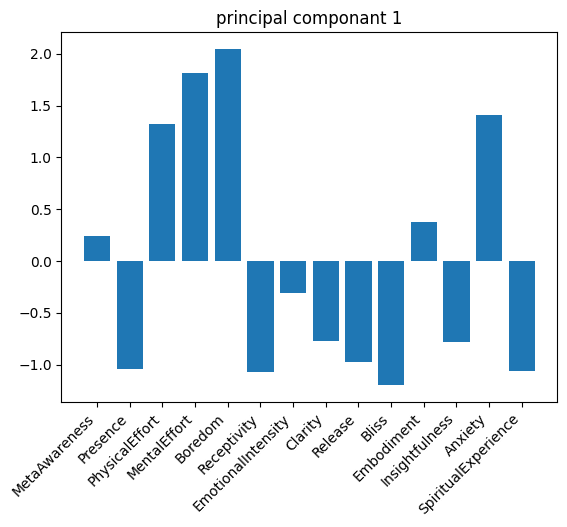

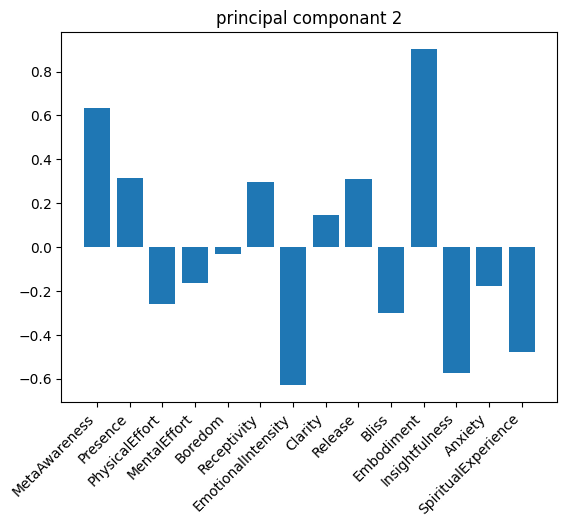

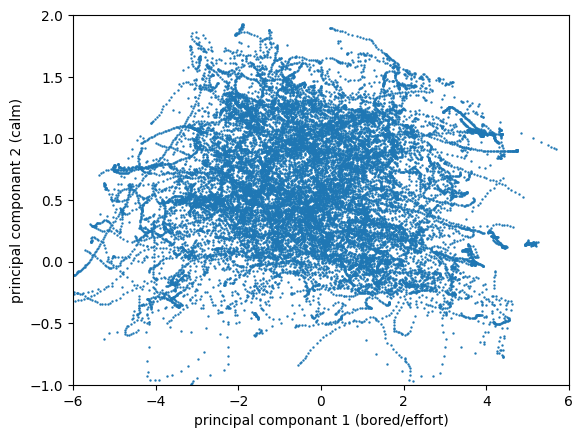

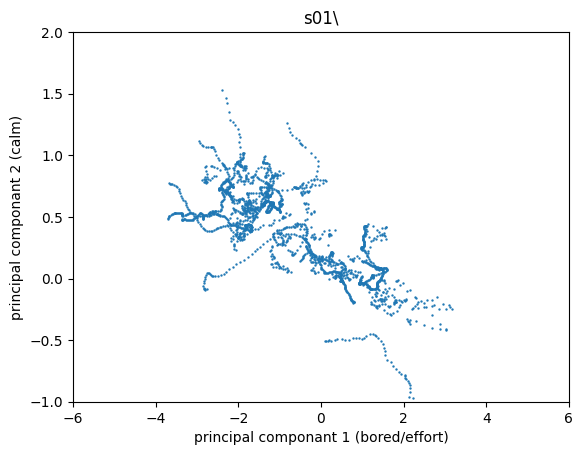

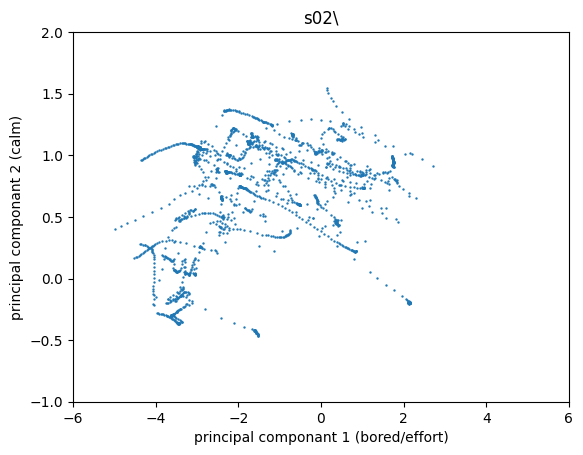

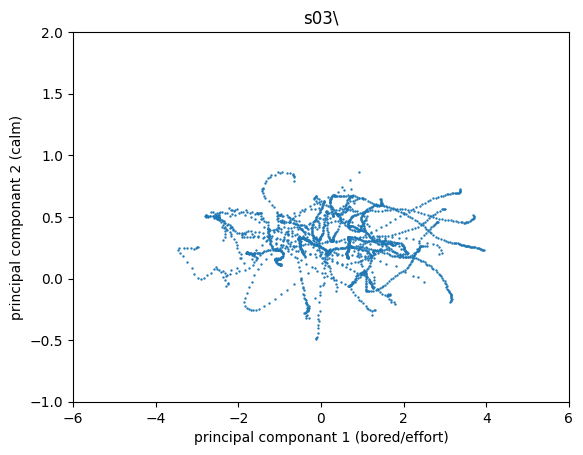

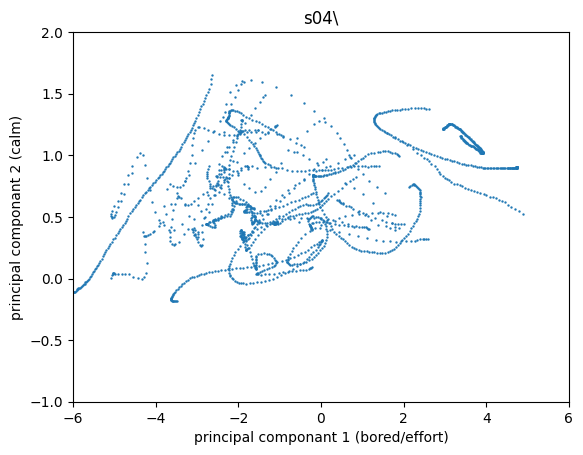

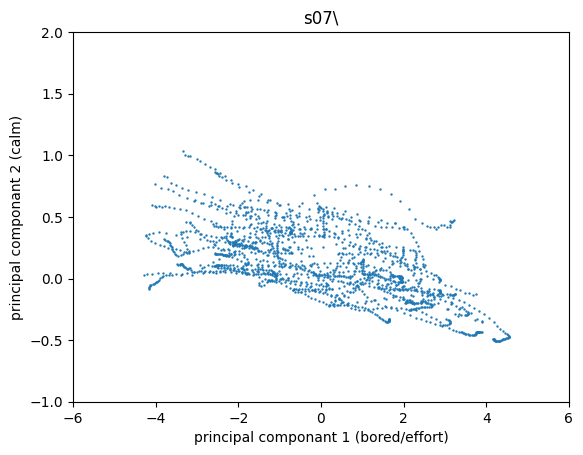

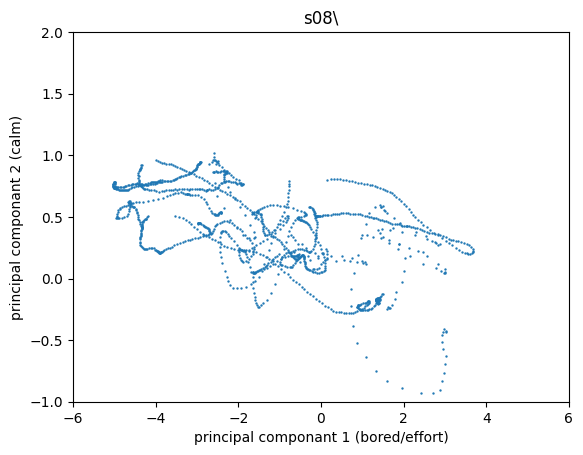

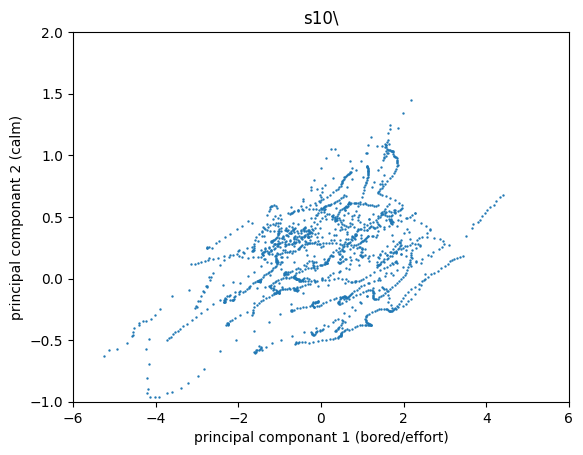

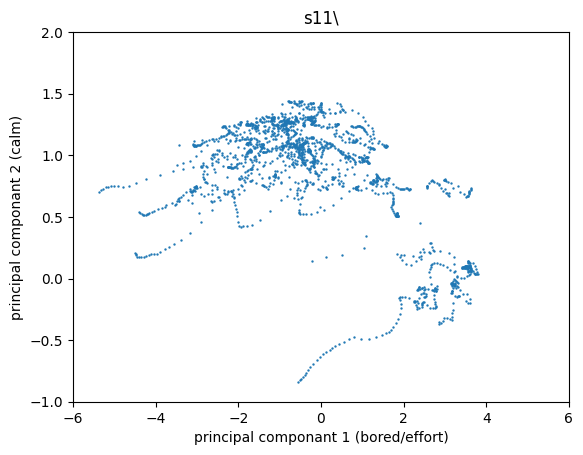

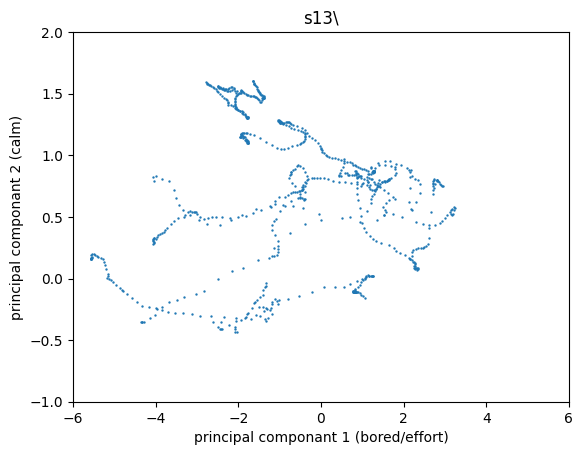

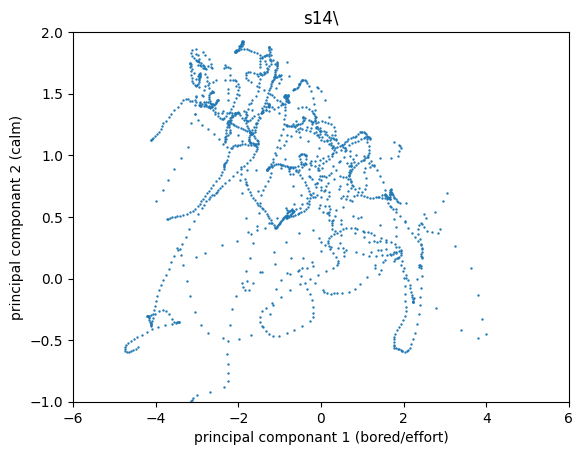

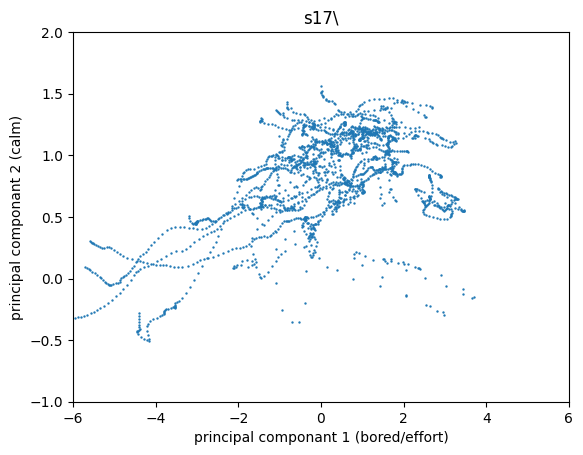

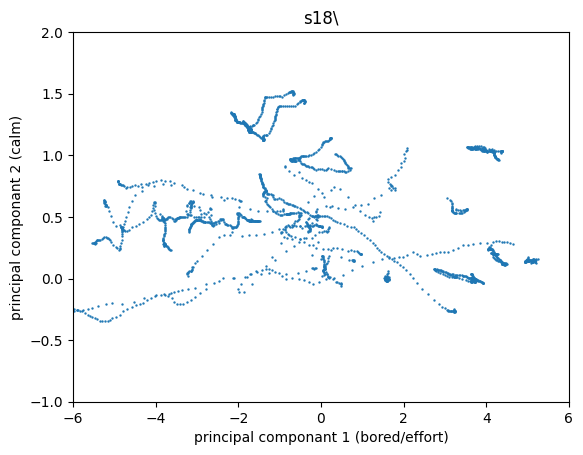

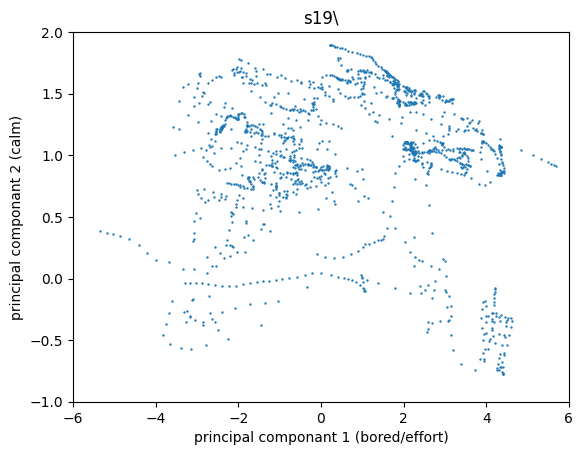

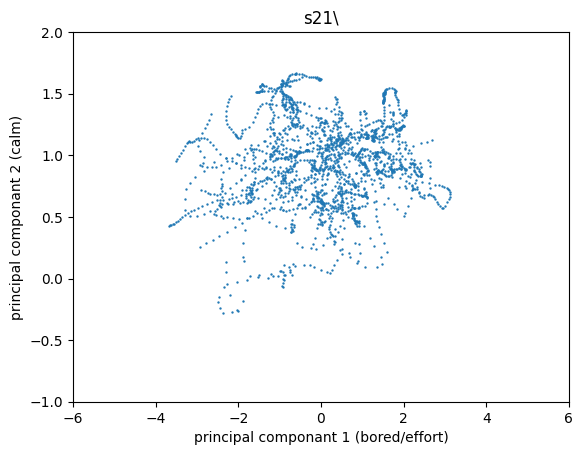

In [9]:
principal_component_finder_instance = principal_component_finder(df_csv_file,feelings,no_dimensions)
principal_components, explained_variance_ratio, df_TET_feelings_prin = principal_component_finder_instance.PCA_TOT()
df_TET_feelings_prin_dict = principal_component_finder_instance.PCA_split(split_csv_array)

In [10]:
traj_kmeans_clustering_trunc_instance =  traj_kmeans_clustering_trunc(df_csv_file, feelings, header, principal_components, n_clust)
data = traj_kmeans_clustering_trunc_instance.data_make()
sum_dist_min = 1000000
id_n_fin = np.zeros(data.shape[2])
clust_fin = np.full((data.shape[0],data.shape[1],n_clust),np.nan)
data_all_clust_fin = np.full((data.shape[0],data.shape[1]+1,data.shape[2]),np.nan)
for n in range(n_rep):
    id_n, clust, dist, aux, data_all_clust, sum_dist = traj_kmeans_clustering_trunc_instance.traj_kmeans_mean(1,50)
    print(f'sum dist is {sum_dist}')
    s = traj_kmeans_clustering_trunc_instance.silhouette_et(data,id_n,n_clust)
    sil = np.sum(s)
    print(f'total silhouettte score is {sil}')
    if sum_dist<sum_dist_min:
        id_n_fin = id_n
        sum_dist_min = sum_dist
        clust_fin = clust
        data_all_clust_fin = data_all_clust

traj_kmeans_clustering_trunc_instance.traj_plots(colours,id_n_fin)
traj_kmeans_clustering_trunc_instance.centroid_plotter(clust_fin,colours)
data_all_clust_finish = traj_kmeans_clustering_trunc_instance.traj_identifier(data_all_clust_fin)
traj_kmeans_clustering_trunc_instance.indiv_plots(data_all_clust_finish,headers,colours)

[[[1.02508754 1.60144428 0.56436252 ... 1.13058381 0.03505201 0.91112915]
  [0.94269684 1.5087993  0.45819697 ... 0.97561634 0.46745222 0.84084315]
  [0.98524322 1.39762201 0.37989417 ... 0.8651157  0.94848256 0.73199908]
  ...
  [0.66631842 2.62168549 2.03060269 ... 1.42193392 1.02863009 1.55215582]
  [0.63014446 2.65520611 2.05186077 ... 1.41075414 1.17865073 1.64287489]
  [0.6067598  2.67466361 2.05320398 ... 1.34897096 1.31369546 1.79198456]]

 [[2.09916876 1.28644764 1.21788574 ... 0.06868428 0.15453668 0.30361549]
  [2.10144182 1.31394439 1.22014464 ... 0.06097322 0.08866913 0.28710347]
  [2.06802958 1.3241038  1.22924561 ... 0.13358183 0.01846608 0.25049913]
  ...
  [1.50722375 1.34929087 1.01374693 ... 0.20664196 0.09730977 0.26903628]
  [1.49807229 1.34487135 1.0147933  ... 0.09432027 0.13050533 0.32741414]
  [1.47824318 1.34160611 1.00671293 ... 0.00509529 0.17916914 0.34648632]]]
[[[6.57877128e-01 8.15203897e-02 1.11860215e+00 ... 2.81354849e+00
   1.71801668e+00 7.71835518e

KeyboardInterrupt: 

sum dist is [25.49252512]
total silhouettte score is 104.48251676459556


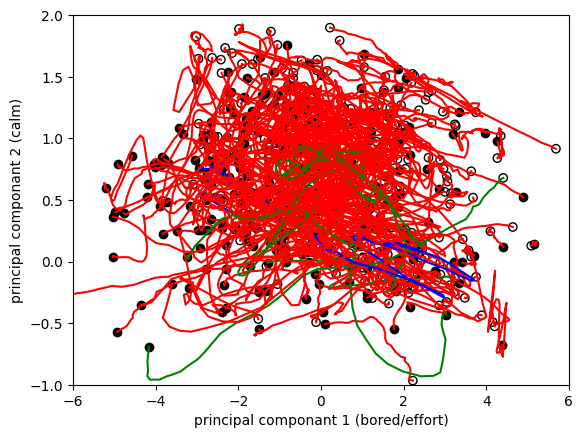

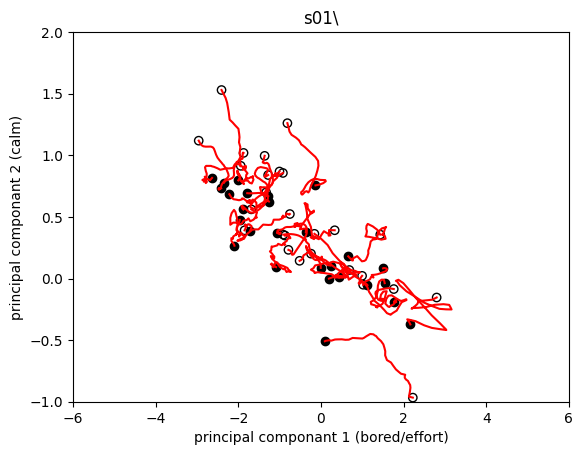

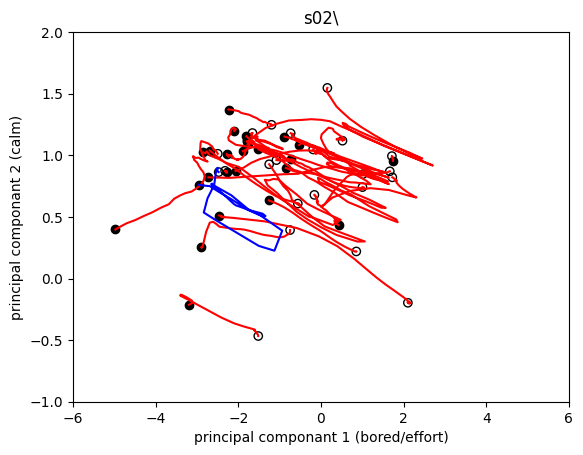

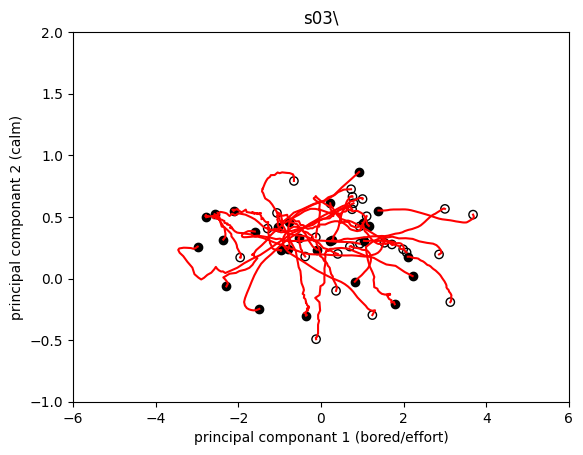

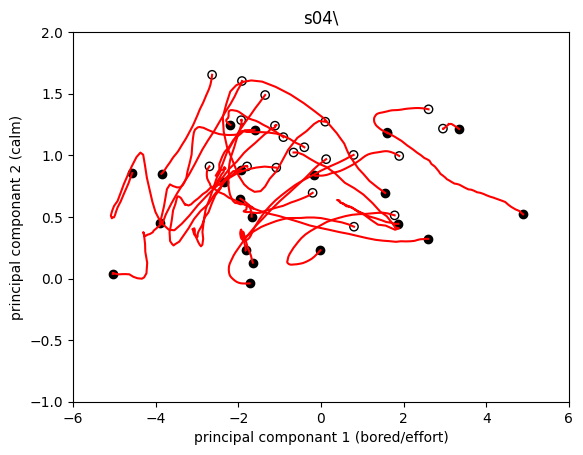

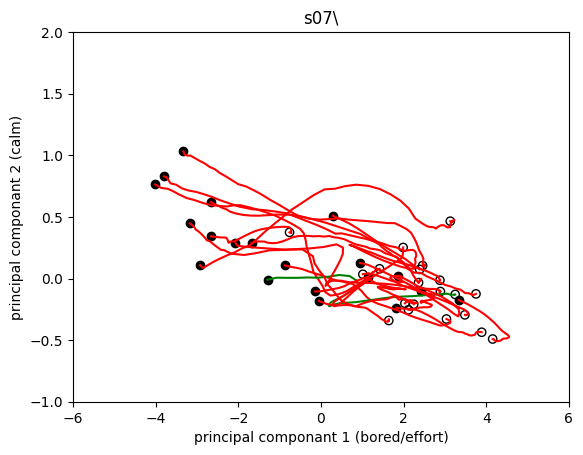

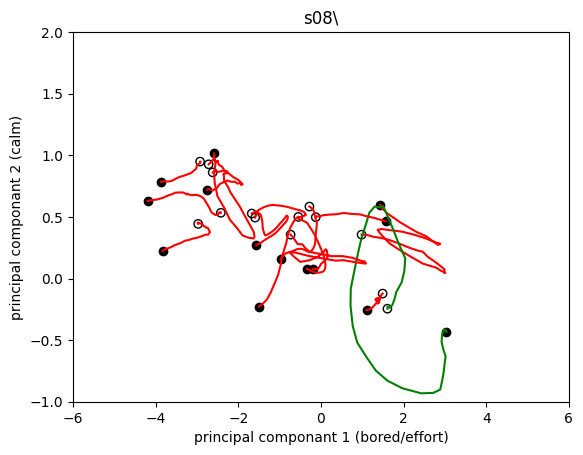

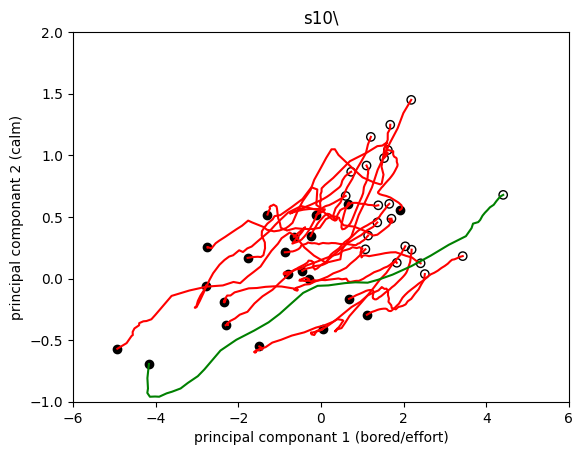

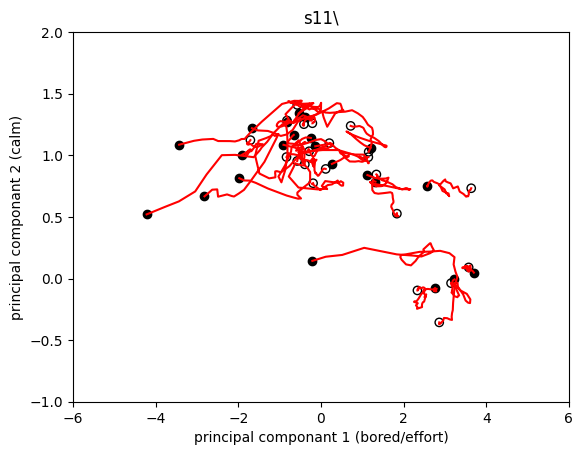

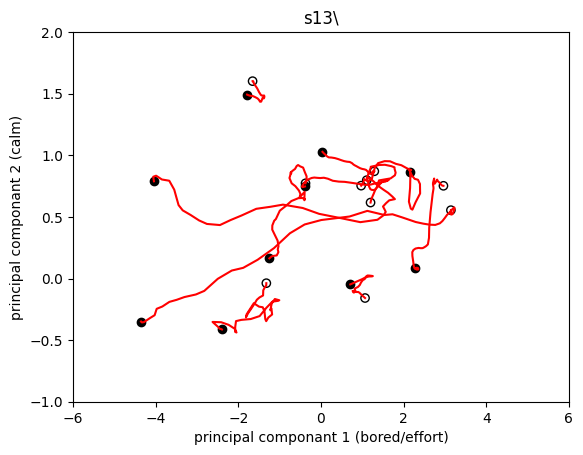

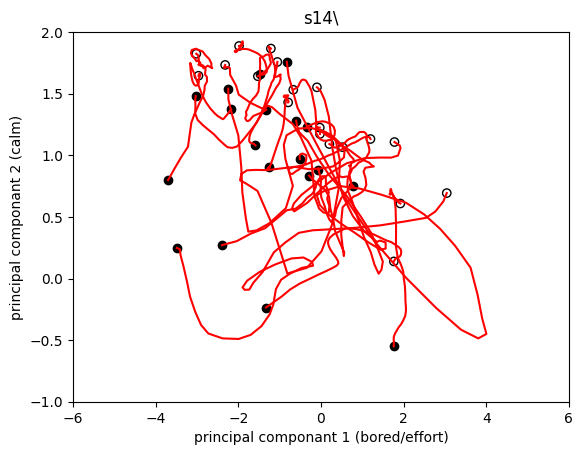

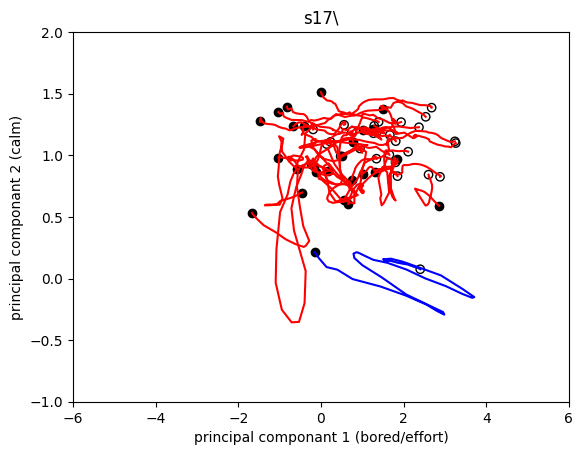

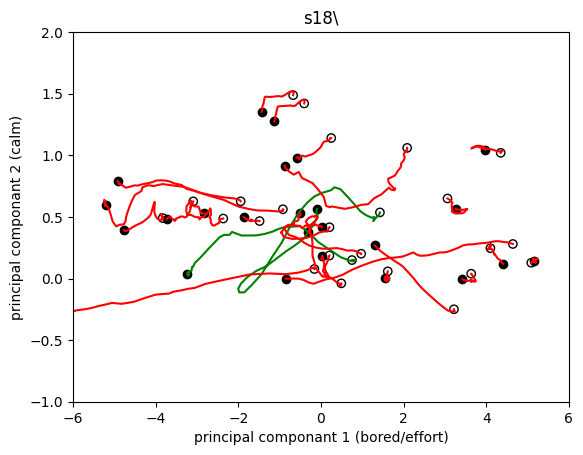

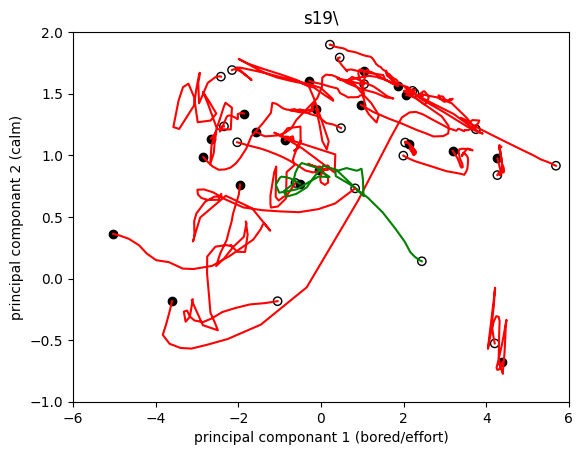

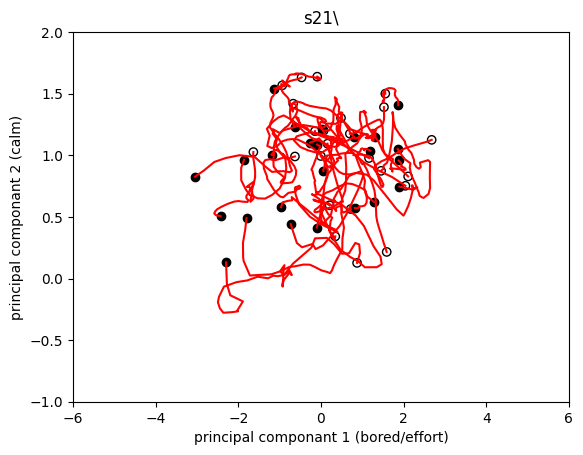

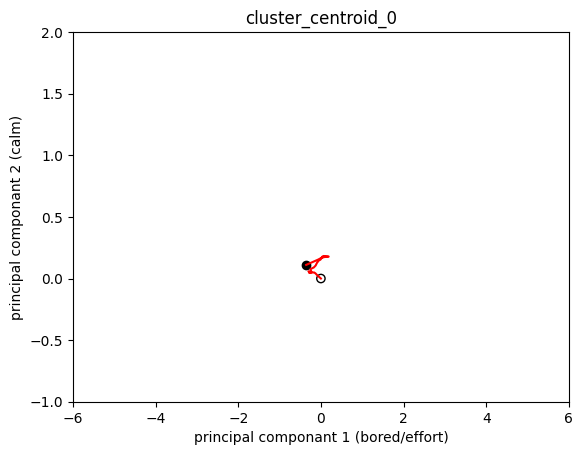

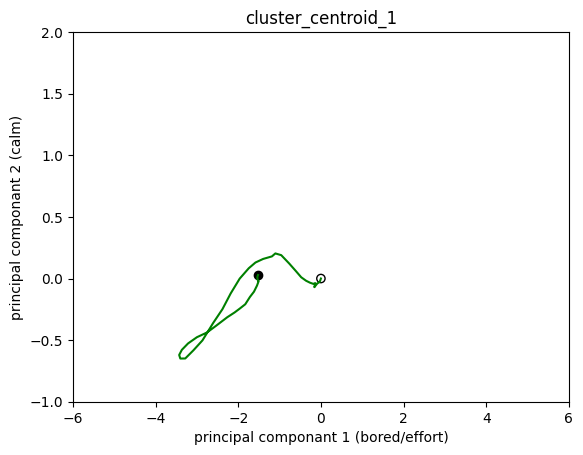

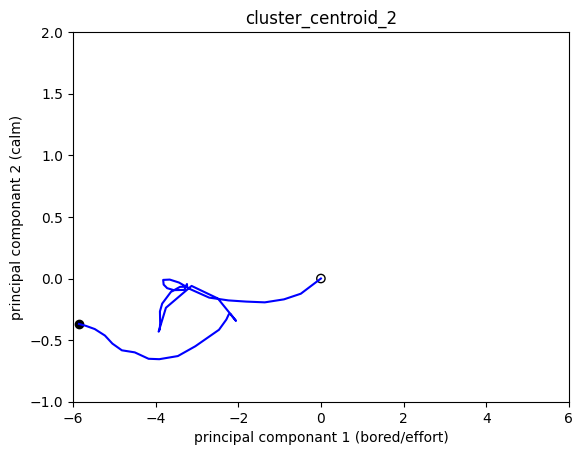

In [ ]:

sum_dist_min_diff = 1000000
id_n_fin_diff = np.zeros(data.shape[2])
clust_fin_diff = np.full((data.shape[0],data.shape[1],n_clust),np.nan)
data_all_clust_fin_diff = np.full((data.shape[0],data.shape[1]+1,data.shape[2]),np.nan)
for n in range(n_rep):
    traj_kmeans_clustering_trunc_instance =  traj_kmeans_clustering_trunc(df_csv_file, feelings, header, principal_components, n_clust)
    id_n_diff, clust_diff, dist_diff, aux_diff, data_all_clust_diff,data_diffs, sum_dist_diff = traj_kmeans_clustering_trunc_instance.traj_kmeans_mean_diffs(1,50)
    print(f'sum dist is {sum_dist_diff}')
    s_diff = traj_kmeans_clustering_trunc_instance.silhouette_et(data_diffs,id_n_diff,n_clust)
    sil_diff = np.sum(s_diff)
    print(f'total silhouettte score is {sil_diff}')
    if sum_dist<sum_dist_min_diff:
        id_n_fin_diff = id_n_diff
        sum_dist_min_diff = sum_dist_diff
        clust_fin_diff = clust_diff
        data_all_clust_fin_diff = data_all_clust_diff
traj_kmeans_clustering_trunc_instance.traj_plots(colours,id_n_fin_diff)
data_all_clust_fin_diff = traj_kmeans_clustering_trunc_instance.traj_identifier(data_all_clust_diff)
traj_kmeans_clustering_trunc_instance.indiv_plots(data_all_clust_fin_diff,headers,colours)
traj_kmeans_clustering_trunc_instance.centroid_plotter_diff(clust_fin_diff,colours)

In [ ]:
traj_kmeans_clustering_interpolate_instance =  traj_kmeans_clustering_interpolate(df_csv_file, feelings, header, principal_components, n_clust)
data_int = traj_kmeans_clustering_interpolate_instance.data_maker()

In [ ]:
traj_kmeans_clustering_interpolate_instance.traj_kmeans_mean()

TypeError: traj_kmeans_clustering_interpolate.traj_kmeans_mean() missing 2 required positional arguments: 'nrep' and 'avg'

In [ ]:
sum_dist_min_int = 1000000
id_n_int_fin = np.zeros(data.shape[2])
clust_int_fin = np.full((data.shape[0],data.shape[1],n_clust),np.nan)
data_all_clust_int_fin = np.full((data.shape[0],data.shape[1]+1,data.shape[2]),np.nan)
for n in range(n_rep):
    id_n_int, clust_int, dist_int, aux_int, data_all_clust_int, sum_dist_int = traj_kmeans_clustering_interpolate_instance.traj_kmeans_mean(1,50)
    print(f'sum dist is {sum_dist}')
    s_int = traj_kmeans_clustering_interpolate_instance.silhouette_et(data_int,id_n_int,n_clust)
    sil_int = np.sum(s)
    print(f'total silhouettte score is {sil_int}')
    if sum_dist_int<sum_dist_min_int:
        id_n_int_fin = id_n_int
        sum_dist_min_int = sum_dist_int
        clust_int_fin = clust_int
        data_all_clust_int_fin = data_all_clust_int

traj_kmeans_clustering_interpolate_instance.traj_plots(colours,id_n_int_fin)
traj_kmeans_clustering_interpolate_instance.centroid_plotter(clust_int_fin,colours)
data_all_clust_int_finish = traj_kmeans_clustering_interpolate_instance.traj_identifier(data_all_clust_int_fin)
traj_kmeans_clustering_interpolate_instance.indiv_plots(data_all_clust_int_finish,headers,colours)

KeyboardInterrupt: 